# Input files for channel run 

This notebook produces input files that are used to run the simulations that were part of this project:

a) wind stress with sinusoidal winds. (Note that this is different from the sin^2 winds that were used in Balwada et al 2018, but same as what was used in Abernathey and Cessi 2014).

b) surface temp restoring. 

c) Topography is flat with a ridge. 

d) Sponge layer restoring on the northern boundary.

e) tracers that will be restored for 3D tracer inversion.

In [1]:
# load modules 
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# set resolution
res = 5 

# set output_directory to save input files. 
output_dir = '/swot/SUM05/dbalwada/input_data/input_files_submeso_channel_new/%02d' %res + 'km_res/'

# set format of binary files 
tp= '>f8'

In [3]:
# function that makes xy grid
def make_grid_xy(n, length=2e6):
    lx, ly = length, length
    nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [4]:
# domain width and length (currently using a square)
Lx = 2e6

# number of center grid points (how many dx fit in the domain)
n = int(Lx/res/1000)

# generate the x,y grid
xc, yc = make_grid_xy(n, Lx)

## Topographic shape 

Large scale shape of topography - flat bottom with gaussian bump 

$$ bathy = -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 2985$ m, $h_0 = 927$ m and $\sigma = 75$ km.

(The particular numbers are chosen to match Ryan's previous experiments, and also work with the vertical grid)

In [10]:
H  = 2985.0
h0 = 927.0
sig= 75.0e3

bathy      = -(H - h0*np.exp(-(xc - Lx/2)**2 / sig**2))
bathy[0,:] = 0.0 # create a wall to the south. By default MITgcm assumes periodic in both directions. 


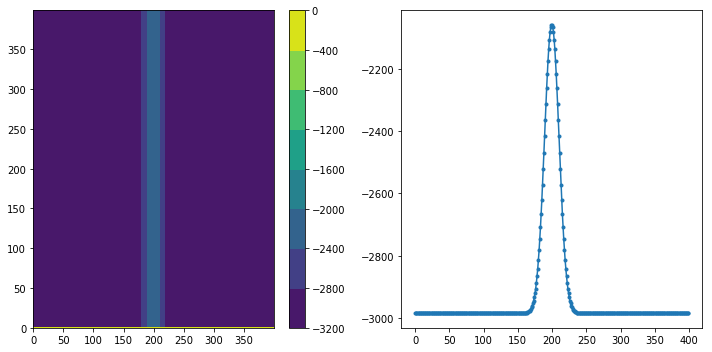

In [11]:
# plot the generated topography for visual verification
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(bathy)
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(bathy[10,:],'.-')
plt.tight_layout()

In [8]:
# save to file
bathy.astype(tp).tofile(output_dir + 'BATHY_flat_bump%03d.bin' % res)

# Winds

In [12]:
tau0 = 0.2
tau = np.zeros([n,n])

# make sure that the wind goes to zero at the north and south boundary within in the domain.
# be careful that one grid point to the south is just land. 
# the way the wind is defined right now, the wavelength changes slightly between runs.
# also make sure that the wind profile looks the same in all the runs with different resolution.

dy = yc[1,1] - yc[0,1]
tau = tau0*(np.sin(np.pi* (yc-dy)/(2000-dy/1000)/1000)) # slightly squeezed wind profile to account 
# for the presence of land cell at the southern most grid cell. 

In [13]:
#tau[yc<=2500.] = 0.
#tau[yc>=(2000e3-5e3)]= 0.

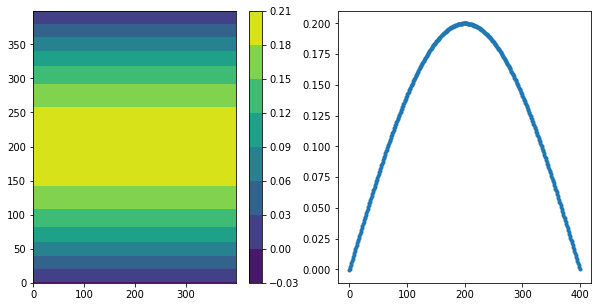

In [14]:
# plot the generated topography for visual verification
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(tau)
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(tau[:,0],'.-')

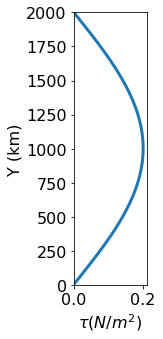

In [15]:
fig = plt.figure(figsize=(2.5,5))
plt.rc('font', size=16)
ax = fig.add_subplot(111)
plt.plot(tau[:,0], yc[:,1]/1e3, linewidth=3.)
plt.xlim([0,0.21])
plt.ylim([0, 2000])
plt.xlabel(r'$ \tau (N/m^2)$')
plt.ylabel('Y (km)')
plt.tight_layout()

#plt.savefig('wind.pdf')

In [22]:
# save wind files 
tau.astype(tp).tofile((output_dir + 'TAU_%03d_%03d.bin'%(tau0*1e4,res)))

## Surface buoyancy conditions 

Restore the surface to a linear buoyancy profile (temperature as there is no salt in the simulation)

\begin{equation}
T(y) = T_o (y/L_y)
\end{equation}

where $T_o = 8^oC$. 

In [29]:
Tmin, Tmax = 0., 8.0
Tsurf = (Tmax-Tmin)*yc/Lx

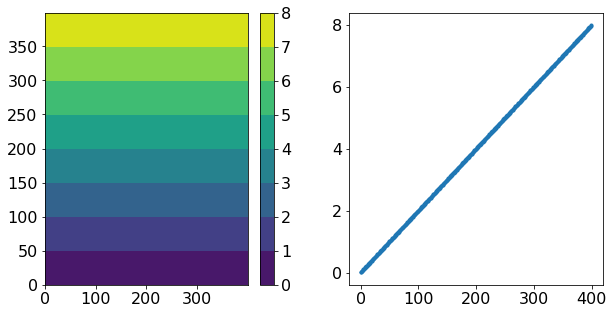

In [30]:
# plot the generated topography for visual verification
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.contourf(Tsurf)
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(Tsurf[:,0],'.-')

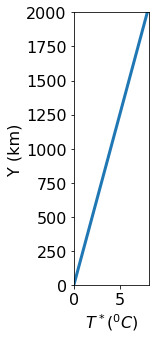

In [31]:
fig = plt.figure(figsize=(2.5,5))
plt.rc('font', size=16)
ax = fig.add_subplot(111)
plt.plot(Tsurf[:,0], yc[:,1]/1e3, linewidth=3.)
plt.xlim([0,8.2])
plt.ylim([0, 2000])
plt.xlabel(r'$ T^* (^0C)$')
plt.ylabel('Y (km)')
plt.tight_layout()

#plt.savefig('temp.pdf')

In [25]:
Tsurf.astype(tp).tofile((output_dir + 'THETA_surf_0to8_%03d.bin' %res))

## Interpolate the initial conditions on stratification

Currently just using the ones from the old runs by Ryan. However the exact intial condition shouldn't be significant. 

In [33]:
hydro_file = '/swot/SUM05/dbalwada/input_data/input_files_submeso_channel_new/05km_res/THETA_init_zon_sym_005.bin'

hydro = np.fromfile(hydro_file, dtype=tp)
hydro_reshaped = hydro.reshape((40,400,400))

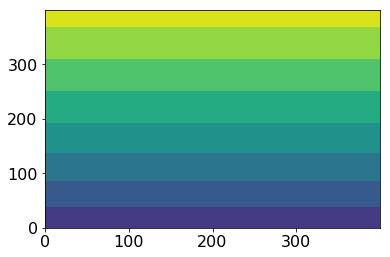

In [38]:
plt.contourf(hydro_reshaped[0,:,:])

In [14]:
# save file
new_temp.astype(tp).tofile(output_dir + 'THETA_init_zon_sym_%03d.bin' % res)

## Sponge layer

In [134]:
# make mask 
y = yc[:,0]
dx = 5e3
f = np.zeros(n)

# linear ramp for mask in the last 100km (have to think how to change it when working in very coarse model)
f[y>= (1900e3 -dx) ] = 1e-5 * (y[y>=1900e3- dx] ) - (1900e3 - dx)/1e5

mask2 = np.tile(f, (400,1))
mask3 = np.tile(mask2.T, (40,1,1))
# this is slightly different from what was used in paper, where there was a zero at the wall. 
# Should work the same regardless. 

In [135]:
# manually input the Z grid
zaxis = np.array([   -5. ,   -15. ,   -25. ,   -36. ,   -49. ,   -64. ,   -81.5,
        -102. ,  -126. ,  -154. ,  -187. ,  -226. ,  -272. ,  -327. ,
        -393. ,  -471.5,  -565. ,  -667.5,  -770.5,  -873.5,  -976.5,
       -1079.5, -1182.5, -1285.5, -1388.5, -1491.5, -1594.5, -1697.5,
       -1800.5, -1903.5, -2006.5, -2109.5, -2212.5, -2315.5, -2418.5,
       -2521.5, -2624.5, -2727.5, -2830.5, -2933.5])

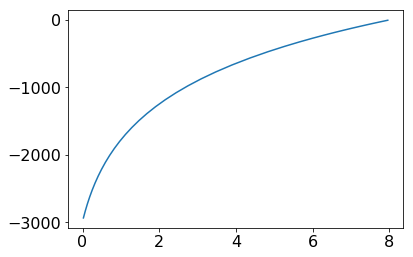

In [136]:
# make sponge layer profile
delT = 8.0 
h = 1000. 
Hmax = 2985.0

# Use expression (2) from Abernathey et al 2011
Tstar = delT*(np.exp(zaxis/h) - np.exp(-Hmax/h))/(1-  np.exp(-Hmax/h))

plt.plot(Tstar, zaxis) 

In [137]:
# Make and save analytical form 
temp_relax_large_analytical = np.tile(Tstar, (400,400,1)).T

temp_relax_large_analytical.astype(tp).tofile(output_dir + 'rbcs_temp_relax_%03d.bin' % res)

In [138]:
#temp_relax_large.astype(tp).tofile(output_dir + 'rbcs_temp_relax_%03d.bin' % res)
mask3.astype(tp).tofile(output_dir + 'rbcs_temp_relax_mask_%03d.bin' % res)

# Multi tracer profiles 
if wanting to do tracer inversion. Needs access to model grids.

In [140]:
data_30 = '/swot/SUM05/dbalwada/channel_model_output/varying_res/05km/run_sponge_flat/'
ds  = open_mdsdataset(data_30, delta_t=300, 
                          prefix=[''],
                          ignore_unknown_vars=True, geometry='cartesian') 

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/dbalwada/channel_model_output/varying_res/05km/run_sponge_flat/. Using default version.
  "in %s. Using default version." % data_dir)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [141]:
# c1 = y/Ly
#[xg,yg,zg] = np.meshgrid(ds.XC, ds.YC, ds.Z)

[zg,yg,xg] = np.meshgrid(ds.Z, ds.YC, ds.XC, indexing='ij')

In [142]:
# Tracers for 3D setup (with ridge in the middle.)
C1 = yg/Lx
C2 = (-zg)/H
C3 = np.cos(2*np.pi*xg/Lx) 
C4 = np.sin(2*np.pi*xg/Lx)
C5 = np.sin(4*np.pi*xg/Lx)
C6 = np.sin(np.pi*yg/Lx)
C7 = np.cos(2*np.pi*yg/Lx)
C8 = np.sin(2*np.pi*yg/Lx)
C9 = np.cos(np.pi*zg/H)
C10 = np.sin(np.pi*zg/H)

In [11]:
C1.astype(tp).tofile(output_dir + 'C1_3D_%03d.bin' % res)
C2.astype(tp).tofile(output_dir + 'C2_3D_%03d.bin' % res)
C3.astype(tp).tofile(output_dir + 'C3_3D_%03d.bin' % res)
C4.astype(tp).tofile(output_dir + 'C4_3D_%03d.bin' % res)
C5.astype(tp).tofile(output_dir + 'C5_3D_%03d.bin' % res)
C6.astype(tp).tofile(output_dir + 'C6_3D_%03d.bin' % res)
C7.astype(tp).tofile(output_dir + 'C7_3D_%03d.bin' % res)
C8.astype(tp).tofile(output_dir + 'C8_3D_%03d.bin' % res)
C9.astype(tp).tofile(output_dir + 'C9_3D_%03d.bin' % res)
C10.astype(tp).tofile(output_dir + 'C10_3D_%03d.bin' % res)

In [13]:
rbcs_mask = np.ones((nz,ny,nx))

In [14]:
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_ones_%03d.bin' % res)

# Tracers restored to values

Some masks for simulation where the tracers were only restored at the boundaries. 

In [24]:
# Constant 1 on surface and south wall. 0 on north wall. 

rbcs_mask = np.zeros((nz,ny,nx))
rbcs_mask[0,:,:] = 1.
rbcs_mask[:,-10:-1,:] = 1.
rbcs_mask[:,0:2,:] = 1.
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_1_%03d.bin' % res)

rbcs_relax = np.zeros((nz,ny,nx))
rbcs_relax[0,:,:] = 1. 
rbcs_relax[:,-10:-1,:] = 0.
rbcs_relax[:,0:2,:] = 1.
rbcs_relax.astype(tp).tofile(output_dir + 'rbcs_relax_1_%03d.bin' % res)

In [26]:
# tracer with linear gradient on the north wall. 0 at surface and south wall.

rbcs_mask = np.zeros((nz,ny,nx))
rbcs_mask[0,:,:] = 1.
rbcs_mask[:,-10:-1,:] = 1.
rbcs_mask[:,0:2,:] = 1.
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_2_%03d.bin' % res)

rbcs_relax = np.zeros((nz,ny,nx))
rbcs_relax[0,:,:] = 0. 
rbcs_relax = -zg/3000
rbcs_relax[:,0:2,:] = 0.
rbcs_relax.astype(tp).tofile(output_dir + 'rbcs_relax_2_%03d.bin' % res)

In [27]:
# tracer with value 1 on the downstream of bump, 0 on the upstream

rbcs_mask = np.zeros((nz,ny,nx))
rbcs_mask[:,:,195:205] = 1.
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_3_%03d.bin' % res)

rbcs_relax = np.zeros((nz,ny,nx))
rbcs_relax[:,:,200:205] = 1. 
rbcs_relax.astype(tp).tofile(output_dir + 'rbcs_relax_3_%03d.bin' % res)

In [28]:
# tracer with value 1 on the downstream of bump, 0 on the upstream

rbcs_mask = np.zeros((nz,ny,nx))
rbcs_mask[:,:,195:205] = 1.
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_4_%03d.bin' % res)

rbcs_relax = np.zeros((nz,ny,nx))
rbcs_relax = (3000+zg)/3000
rbcs_relax[:,:,195:200] = 0.
rbcs_relax.astype(tp).tofile(output_dir + 'rbcs_relax_4_%03d.bin' % res)